<a href="https://colab.research.google.com/github/william-engel/JetsonNano/blob/main/Tensorflow_Object_Detection_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection API
TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere.

In this project we are going to use a pretrained version of SSD MobileNet v2 320x320. However there exist a number of models you can use, all of which are listed in [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

In [1]:
import tensorflow as tf
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
%%capture 

# Download pretrained model from Tensorflow Hub
model_origin = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz'
fname = os.path.basename(model_origin)
model_dir = fname.replace('.tar.gz', '')

!wget {model_origin} # download model
!tar -xzf {fname}    # untar model
!rm {fname}          # delete tar-file

In [3]:
# Lets see whats inside the model directory
!ls {model_dir}

checkpoint  pipeline.config  saved_model


In [4]:
# Load detection model
detection_model = tf.saved_model.load(os.path.join(model_dir, 'saved_model'))
detection_model_fn = detection_model.signatures['serving_default']

229376/227516 [==============================] - 0s 2us/step


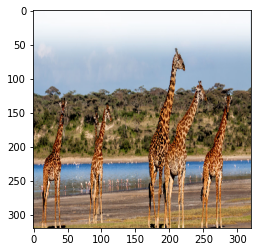

In [5]:
# get random test image from the internet
def get_resized_tf_image(image_origin, target_size):
  # to avoid naming conflicts save image with timestamp
  dateTimeObj = datetime.now()
  fname = '{}.jpg'. format(dateTimeObj.strftime("%d_%m_%Y_%H_%M_%S"))
  path_to_image = tf.keras.utils.get_file(fname = fname, origin = image_origin)
  image = tf.keras.preprocessing.image.load_img(path = path_to_image, target_size = target_size)
  np_image = np.asarray(image)
  tf_image = tf.convert_to_tensor(np_image, dtype = tf.uint8)
  return tf_image

image_origin = 'https://www.afromaxx.com/wp-content/uploads/2016/03/SLIDE-hoch-giraffe.jpg'
target_size = (320, 320)
sample_image = get_resized_tf_image(image_origin, target_size)

plt.imshow(sample_image) # show image
plt.show()

In [6]:
# make prediction
results = detection_model_fn(sample_image[tf.newaxis,...])

In [7]:
# let's look at the result
# among other things we recieved a list of detected classes associated with their detection scores and detection boxes
print(results.keys())

dict_keys(['detection_boxes', 'raw_detection_boxes', 'detection_scores', 'raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections'])


In [8]:
# visualize the results
# we could implement this functions on our own, but for convenience we are going to use an existing function
# from the official tensorflow object detection repository

In [9]:
# Install the Object Detection API
%%bash
git clone --depth 1 https://github.com/tensorflow/models
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1606870 sha256=b751fddc6afa341d3f22935fff2f347e7eab4a4f5bc87f45163b0d50d56538e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofb_pbg8/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=1d9361535718d7bfe2f49536648eac55290a81891a6e806606da4370b01b9471
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=5e51cc6e2040f167a3c5b09a4bb56d487052dd6fd5cc4b6a0858ac6e94194f7f
  Stored in directory: /root/.cache/pip/wheels/fe/a7/05/23e3699975fc20f8a30e00ac1e515ab8c61168e982abe4ce70
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=8f42c17eda4235eb115f7ba97e152dd8b7a94f7e664aef0e1dc4fca5cc

Cloning into 'models'...
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.26.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [10]:
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

In [11]:
# Load label map data (for plotting).
# Label maps correspond index numbers to category names, so that when our convolution network predicts 5, 
# we know that this corresponds to airplane.
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [12]:
def visualize_results(image, results):

  # convert result to numpy values
  result = {key:value.numpy() for key,value in results.items()}

  image_with_detections = np.asarray(image).copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image = image_with_detections,
      boxes = result['detection_boxes'][0],
      classes = result['detection_classes'][0].astype(int),
      scores = result['detection_scores'][0],
      category_index = category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.40
  )

  return image_with_detections

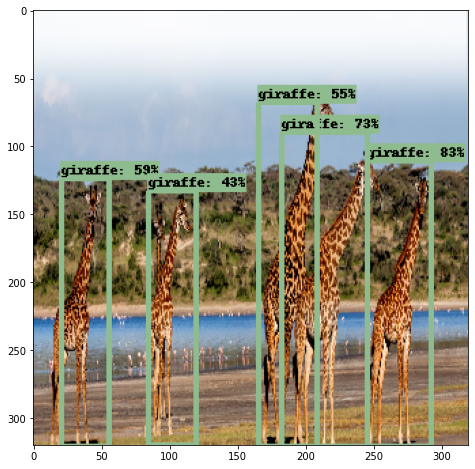

In [13]:
# visualize result
image_with_detections = visualize_results(sample_image, results)

plt.figure(figsize=(8,8))
plt.imshow(image_with_detections)
plt.show()

## Test Inference

In [14]:
from google.colab import files
import cv2
from google.colab.patches import cv2_imshow
import time

In [15]:
# upload test video file
sample_video_dir = os.path.join('drive', 'MyDrive', 'sample_video')

if not os.path.exists(sample_video_dir):
  os.mkdir(sample_video_dir)

  uploaded = files.upload()

  for fn in uploaded.keys():
    shutil.move(os.path.join(os.getcwd(), fn), os.path.join(sample_video_dir, fn))

In [16]:
sample_video_path = os.path.join(sample_video_dir, 'test_video.mp4')

In [ ]:
def run_inference_on_videostream(model_fn = None, num_warmup_rounds = 300, streaming_adress = None,
                                 save_video_with_detections = False, target_size = (320,320), num_frames = 300):
  
  def preprocess_frame(frame = None, target_size = None):
    frame = cv2.resize(frame, dsize = target_size)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    return tf.convert_to_tensor(frame, dtype = tf.uint8)

  cap = cv2.VideoCapture(streaming_adress)

  # create output video
  if save_video_with_detections:
    dateTimeObj = datetime.now()
    fname = 'result_{}.mp4'. format(dateTimeObj.strftime("%d_%m_%Y_%H_%M_%S"))
    out = cv2.VideoWriter(fname, cv2.VideoWriter_fourcc(*'MP4V'), 15, target_size) 

  # test streaming rate
  print('testing streamingrate...')
  elapsed_time = []
  for i in range(100):
    start_time = time.time()
    ret, frame = cap.read()
    end_time = time.time()
    elapsed_time = np.append(elapsed_time, end_time - start_time)
  print('Streaming with: %.0d fps'% (100 / elapsed_time.sum()))
  
  # warmup
  print('running warmup...')
  # get warmup image
  _, warmup_image = cap.read()
  warmup_image = preprocess_frame(warmup_image, target_size)
  # run num_warmup_rounds
  for i in range(num_warmup_rounds):
    results = model_fn(warmup_image[tf.newaxis,...])
  # reset video
  cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

  
  # inference
  print('running inference...')
  elapsed_time = []
  counter = 0
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == True:
        counter += 1

        # preprocess frame
        frame = preprocess_frame(frame, target_size)

        # capture inference time
        start_time = time.time()
        results = model_fn(frame[tf.newaxis,...])
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)

        # visualizer results
        if save_video_with_detections:
          image_with_detections = visualize_results(frame, results)
          out.write(image_with_detections)

        # print intermediate result
        if counter % 200 == 0:
          print('Step {}: {:4.1f}ms'.format(counter, (elapsed_time[-50:].mean()) * 1000))
        
        if counter == num_frames: break

      else:
          break

  cap.release()
  out.release() 

  print('Throughput: {:.0f} fps'.format(num_frames / elapsed_time.sum()))

  if save_video_with_detections:
    files.download(fname)

In [20]:
def run_inference_on_video(model_fn = None, num_warmup_rounds = 300, filename = None,
                           save_video_with_detections = False, target_size = (320,320)):
  
  def preprocess_frame(frame = None, target_size = None):
    frame = cv2.resize(frame, dsize = target_size)
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    return tf.convert_to_tensor(frame, dtype = tf.uint8)

  elapsed_time = []

  cap = cv2.VideoCapture(filename)
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # create output video
  if save_video_with_detections:
    dateTimeObj = datetime.now()
    fname = 'result_{}.mp4'. format(dateTimeObj.strftime("%d_%m_%Y_%H_%M_%S"))
    out = cv2.VideoWriter(fname, cv2.VideoWriter_fourcc(*'MP4V'), 15, target_size) 

  # warmup
  print('running warmup...')
  # get warmup image
  _, warmup_image = cap.read()
  warmup_image = preprocess_frame(warmup_image, target_size)
  # run num_warmup_rounds
  for i in range(num_warmup_rounds):
    results = model_fn(warmup_image[tf.newaxis,...])
  # reset video
  cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

  # inference
  print('running inference...')
  counter = 0
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == True:
        counter += 1

        # preprocess frame
        frame = preprocess_frame(frame, target_size)

        # capture inference time
        start_time = time.time()
        results = model_fn(frame[tf.newaxis,...])
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)

        # visualizer results
        if save_video_with_detections:
          image_with_detections = visualize_results(frame, results)
          out.write(image_with_detections)

        # print intermediate result
        if counter % 200 == 0:
          print('Step {}: {:4.1f}ms'.format(counter, (elapsed_time[-50:].mean()) * 1000))

      else:
          break

  cap.release()
  out.release() 

  print('Throughput: {:.0f} fps'.format(total_frames / elapsed_time.sum()))

  if save_video_with_detections:
    files.download(fname)

In [21]:
run_inference_on_video(model_fn = detection_model_fn,
                       num_warmup_rounds = 300,
                       filename = sample_video_path,
                       save_video_with_detections = True,
                       target_size = (320,320))

running warmup...
running inference...
Step 200: 58.0ms
Step 400: 61.0ms
Step 600: 62.3ms
Step 800: 62.7ms
Step 1000: 59.7ms
Step 1200: 58.2ms
Throughput: 17 fps


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TensorRT

In [ ]:
os.environ['TF_CPP_VMODULE'] = 'segment=2,convert_graph=2,convert_nodes=2,trt_engine=1,trt_logger=2'

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
#tf.get_logger().setLevel('ERROR')

In [ ]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params._replace(precision_mode = trt.TrtPrecisionMode.FP16,
                           max_workspace_size_bytes = int(8e9),
                           maximum_cached_engines=100)


converter = trt.TrtGraphConverterV2(
    input_saved_model_dir = os.path.join(model_dir, 'saved_model'),
    conversion_params = conversion_params)

converter.convert()

def my_input_fn():
  inp1 = sample_image[tf.newaxis,...]
  yield (tf.expand_dims(inp1, axis = 0))

converter.build(input_fn=my_input_fn)
converter.save('resnet50_saved_model_TFTRT_FP16')


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


In [ ]:
optimized_model = tf.saved_model.load('resnet50_saved_model_TFTRT_FP16', tags=[tf.compat.v1.saved_model.tag_constants.SERVING])
optimized_model_fn = saved_model_loaded.signatures['serving_default']

In [ ]:
run_inference_on_video(model_fn = optimized_model_fn,
                       num_warmup_rounds = 300,
                       warmup_image = sample_image,
                       video_path = sample_video_path,
                       save_video_with_detections = True)

running warmup...
running inference...
Step 299: 55.3ms
Step 299: 56.9ms
Step 299: 58.5ms
Step 299: 57.9ms
Step 299: 57.1ms
Step 299: 56.0ms
Throughput: 18 fps


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>